In [1]:
%matplotlib widget

import math
import os
from os import path

from matplotlib import pyplot as plt
import numpy as np

plt.close()


# TODO: Add burstiness analysis from receiver pcap, flow level


def parse_burst_times(out_dir):
    with open(path.join(out_dir, "log", "burst_times.log"), "r") as fil:
        return [parse_times_line(line) for line in fil if line.strip()[0] != "#"]


def parse_times_line(line):
    # Format: <start time seconds> <end time seconds>
    parts = line.strip().split(" ")
    assert len(parts) == 2
    return [float(sec) for sec in parts]


def parse_queue_line(line):
    # Format: <timestamp seconds> <num packets> <backlog time microseconds>
    parts = line.strip().split(" ")
    assert len(parts) == 2
    time_sec, packets = parts
    time_sec = float(time_sec)
    packets = int(packets)
    # backlog_us = float(backlog_us)
    return time_sec, packets  # , backlog_us


def parse_mark_line(line):
    # Format <timestamp seconds>
    parts = line.strip().split(" ")
    assert len(parts) == 1
    return (float(parts[0]), None)


def parse_drop_line(line):
    # Format: <timestamp seconds> <drop type>
    parts = line.strip().split(" ")
    assert len(parts) == 2
    time_sec, drop_type = parts
    time_sec = float(time_sec)
    drop_type = int(drop_type)
    return time_sec, drop_type    


def separate_samples_into_bursts(samples, burst_times):
    bursts = [[]]
    burst_idx = 0
    for sample_idx, sample in enumerate(samples):
        time_sec, _ = sample
        if burst_times[burst_idx][0] <= time_sec <= burst_times[burst_idx][1]:
            # This sample is part of the current burst.
            bursts[burst_idx].append(sample)
            continue

        if (
            burst_idx < len(burst_times) - 1
            and time_sec >= burst_times[burst_idx + 1][0]
        ):
            # This sample is part of the next burst.
            burst_idx += 1
            bursts.append([sample])
        # Discard sample...it's not in a burst.
        
    # Make all bursts start at time=0.
    return [[(sample[0] - burst[0][0], sample[1]) for sample in burst]
               for burst in bursts]


def graph_queue(out_dir, queue_name, burst_times):
    queue_prefix = (
        "incast_queue" if queue_name == "Incast Queue" else
        ("uplink_queue" if queue_name == "Uplink Queue" else None))
    assert queue_prefix is not None
    depth_flp = path.join(out_dir, f"{queue_prefix}_depth.log")
    mark_flp = path.join(out_dir, f"{queue_prefix}_mark.log")
    drop_flp = path.join(out_dir, f"{queue_prefix}_drop.log")
    
    depth_samples = []
    with open(depth_flp, "r") as fil:
        depth_samples = [
            parse_queue_line(line) for line in fil if line.strip()[0] != "#"
        ]
    burst_depths = separate_samples_into_bursts(depth_samples, burst_times)
    
    mark_samples = []
    with open(mark_flp, "r") as fil:
        mark_samples = [
            parse_mark_line(line) for line in fil if line.strip()[0] != "#"
        ]
    burst_marks = separate_samples_into_bursts(mark_samples, burst_times)
    
    drop_samples = []
    with open(drop_flp, "r") as fil:
        drop_samples = [
            parse_drop_line(line) for line in fil if line.strip()[0] != "#"
        ]
    burst_drops = separate_samples_into_bursts(drop_samples, burst_times)

    num_bursts = len(burst_depths)
    with plt.ioff():
        fig, axes = plt.subplots(figsize=(10, 3 * num_bursts), nrows=num_bursts, ncols=1)
    if num_bursts == 1:
        axes = [axes]
    else:
        axes = axes.flatten()        

    for burst_idx, (ax, burst) in enumerate(zip(axes, burst_depths)):
        # Plot marks and drops on a second y axis

        # Instantiate a second axes that shares the same x-axis                
        ax2 = ax.twinx()        
        
        # If there are marks, plot them...
        if burst_idx < len(burst_marks) and len(burst_marks[burst_idx]):
            mark_xs, _ = zip(*burst_marks[burst_idx])
            mark_ys = [0.5] * len(mark_xs)
            ax2.plot(mark_xs, mark_ys, "+", color="orange", label="ECN marks")        

        # If there are drops, plot them...
        if burst_idx < len(burst_drops) and len(burst_drops[burst_idx]):
            drop_xs, _ = zip(*burst_drops[burst_idx])
            drop_ys = [1] * len(drop_xs)        
            ax2.plot(drop_xs, drop_ys, "x", color="red", label="drops")

        ax2.set_ylim(bottom=0)
        # Hide ytick labels
        ax2.set_yticks([])

        # Plot depth
        xs, ys = zip(*burst)
        blue = 'tab:blue'
        ax.plot(xs, ys, drawstyle="steps-post", color=blue)
        ax.set_title(f"{queue_name} Length: Burst {burst_idx + 1} of {num_bursts}")
        ax.set_xlabel("time (seconds)")
        ax.set_ylabel("queue length (packets)", color=blue)
        # ax2.set_ylabel("queue events")
        ax.tick_params(axis='y', labelcolor=blue)
        ax.set_ylim(bottom=0)
        ax2.legend()          

    plt.tight_layout()
    # Change the toolbar position        
    fig.canvas.toolbar_position = 'left'        
    # If true then scrolling while the mouse is over the canvas will not move the entire notebook
    fig.canvas.capture_scroll = True
    fig.show()
    
    
def parse_cwnd_line(line):
    parts = line.strip().split(" ")
    assert len(parts) == 2
    time_sec, cwnd_bytes = parts
    time_sec = float(time_sec)
    cwnd_bytes = int(cwnd_bytes)
    return time_sec, cwnd_bytes
    

def parse_cwnds(flp):
    with open(flp, "r") as fil:
        return [parse_cwnd_line(line) for line in fil if line.strip()[0] != "#"]
    
def graph_sender_cwnd(out_dir, burst_times):
    cwnd_flps = [
        path.join(out_dir, fln)
        for fln in os.listdir(out_dir)
        if fln.startswith("sender") and fln.endswith("_cwnd.log")]
    
    # print(len(cwnd_flps))
    
    sender_to_cwnds_by_burst = {
        int(path.basename(flp).split("_")[0][6:]): separate_samples_into_bursts(parse_cwnds(flp), burst_times) for flp in cwnd_flps
    }
    
    # print(len(sender_to_cwnds_by_burst))
    
    num_bursts = len(burst_times)
    with plt.ioff():
        fig, axes = plt.subplots(figsize=(10, 3 * num_bursts), nrows=num_bursts, ncols=1)
    if num_bursts == 1:
        axes = [axes]
    else:
        axes = axes.flatten()                    
    
    for burst_idx, ax in enumerate(axes):
        ax.set_title(f"Sender CWNDs: Burst {burst_idx + 1} of {len(burst_times)}")
        ax.set_xlabel("time (seconds)")
        ax.set_ylabel("CWND (bytes)")
            
        for sender, bursts in sender_to_cwnds_by_burst.items():        
            if len(bursts[burst_idx]) == 0:
                continue
            # try:
            xs, ys = zip(*bursts[burst_idx])    
            # except:
            #     print("sender", sender)
            #     print(burst_idx)
            #     print(len(bursts))
            #     print(bursts)
            #     print(bursts[burst_idx])
            #     raise
            ax.plot(xs, ys, label=sender, drawstyle="steps-post", alpha=0.75)
            
        ax.set_ylim(bottom=0)
     
    plt.tight_layout()
    # Change the toolbar position        
    fig.canvas.toolbar_position = 'left'        
    # If true then scrolling while the mouse is over the canvas will not move the entire notebook
    fig.canvas.capture_scroll = True
    fig.show()
    
    return sender_to_cwnds_by_burst


def graph_avg_cwnd(sender_to_cwnds_by_burst, num_bursts):
    with plt.ioff():
        fig, axes = plt.subplots(figsize=(10, 3 * num_bursts), nrows=num_bursts, ncols=1)
    if num_bursts == 1:
        axes = [axes]
    else:
        axes = axes.flatten()        
    
    sender_to_cwnds_by_burst_interp = {
        sender: [] for sender in sender_to_cwnds_by_burst.keys()
    }
    for burst_idx, ax in enumerate(axes):
        end_sec = max(bursts[burst_idx][-1][0] for bursts in sender_to_cwnds_by_burst.values() if len(bursts[burst_idx]) > 0)
        new_xs = list(x / 1e6 for x in range(math.ceil(end_sec * 1e6) + 1))
        
        sender_to_new_cwnds = {
            sender: np.interp(new_xs, *zip(*bursts[burst_idx])) 
            for sender, bursts in sender_to_cwnds_by_burst.items()
            if len(bursts[burst_idx]) > 0
        }
        for sender, new_cwnds in sender_to_new_cwnds.items():
            sender_to_cwnds_by_burst_interp[sender].append(list(zip(new_xs, new_cwnds)))
        
        avg_ys = np.mean(list(sender_to_new_cwnds.values()), axis=0)
        stdev_ys = np.std(list(sender_to_new_cwnds.values()), axis=0)
        min_ys = np.min(list(sender_to_new_cwnds.values()), axis=0)
        max_ys = np.max(list(sender_to_new_cwnds.values()), axis=0)        

        ax.fill_between(new_xs, min_ys, max_ys, alpha=0.25, label="min/max")
        ax.fill_between(new_xs, avg_ys - stdev_ys, avg_ys + stdev_ys, alpha=0.5, label="avg +/- stdev")        
        ax.plot(new_xs, avg_ys, label="avg")        
        
        ax.set_title(f"Average CWND across senders: Burst {burst_idx + 1} of {len(burst_times)}")
        ax.set_xlabel("time (seconds)")
        ax.set_ylabel("CWND (bytes)")
        ax.set_ylim(bottom=0)
        ax.legend()
        
    plt.tight_layout()
    # Change the toolbar position        
    fig.canvas.toolbar_position = 'left'        
    # If true then scrolling while the mouse is over the canvas will not move the entire notebook
    fig.canvas.capture_scroll = True
    fig.show()    

    # Flatten all senders and bursts.
    traces = [
        burst
        for bursts in sender_to_cwnds_by_burst_interp.values()        
        # Throw away the first burst, because it always looks different.
        for burst in bursts[1:]
    ]
    # Build the combined xs. 
    end_sec = max(trace[-1][0] for trace in traces)
    new_xs = [x / 1e6 for x in range(math.ceil(end_sec * 1e6) + 1)]
    # Pad end of traces with 0s so that they are all the same length.
    for trace_idx, trace in enumerate(traces):
        if trace[-1][0] == end_sec:
            continue
        last_cwnd = trace[-1][1]
        trace.extend([(x / 1e6, last_cwnd) for x in range(math.ceil(trace[-1][0] * 1e6), math.ceil(end_sec * 1e6))])
    # Extract just the ys from the traces.
    traces_ys = [tuple(zip(*trace))[1] for trace in traces]
    
    avg_ys = np.mean(traces_ys, axis=0)
    stdev_ys = np.std(traces_ys, axis=0)
    min_ys = np.min(traces_ys, axis=0)
    max_ys = np.max(traces_ys, axis=0)            
        
    with plt.ioff():
        fig, ax = plt.subplots(figsize=(10, 3), nrows=1, ncols=1)
    ax.fill_between(new_xs, min_ys, max_ys, alpha=0.25, label="min/max")
    ax.fill_between(new_xs, avg_ys - stdev_ys, avg_ys + stdev_ys, alpha=0.5, label="avg +/- stdev")
    ax.plot(new_xs, avg_ys, label="avg")
    ax.set_title("Average CWND across all bursts and senders")
    ax.set_xlabel("time (seconds)")
    ax.set_ylabel("CWND (bytes)")
    ax.set_ylim(bottom=0)
    ax.legend()
        
    plt.tight_layout()
    # Change the toolbar position        
    fig.canvas.toolbar_position = 'left'        
    # If true then scrolling while the mouse is over the canvas will not move the entire notebook
    fig.canvas.capture_scroll = True
    fig.show()    
    return sender_to_cwnds_by_burst_interp
    
    
def graph_total_cwnd(sender_to_cwnds_by_burst_interp, num_bursts):
    with plt.ioff():
        fig, axes = plt.subplots(figsize=(10, 3 * num_bursts), nrows=num_bursts, ncols=1)
    if num_bursts == 1:
        axes = [axes]
    else:
        axes = axes.flatten()        
    
    for burst_idx, ax in enumerate(axes):
        # print("Burst samples:", burst_idx)
        # for bursts in sender_to_cwnds_by_burst_interp.values():
        #     print(len(bursts[burst_idx]), bursts[burst_idx][0][0], bursts[burst_idx][-1][0])
            
        sum_ys = np.sum([tuple(zip(*bursts[burst_idx]))[1] for bursts in sender_to_cwnds_by_burst_interp.values()], axis=0)
        ax.plot(tuple(zip(*list(sender_to_cwnds_by_burst_interp.values())[0][burst_idx]))[0], sum_ys)
        
        ax.set_title(f"Total CWND across senders: Burst {burst_idx + 1} of {len(burst_times)}")
        ax.set_xlabel("time (seconds)")
        ax.set_ylabel("CWND (bytes)")
        ax.set_ylim(bottom=0)
        
    plt.tight_layout()
    # Change the toolbar position        
    fig.canvas.toolbar_position = 'left'        
    # If true then scrolling while the mouse is over the canvas will not move the entire notebook
    fig.canvas.capture_scroll = True
    fig.show()

In [2]:
OUT_DIR = "/data_hdd/incast/out/15-100-3"
burst_times = parse_burst_times(OUT_DIR)
burst_times = [(start, (start + 0.1) if (end - start) > 0.1 else end) for start, end in burst_times]
# burst_times = [[a, a + 0.100] for a, b in burst_times]
print(burst_times)
# burst_times = [[2, 2.1]]

[(2.1, 2.11561), (3.11561, 3.13123), (4.13123, 4.14684)]


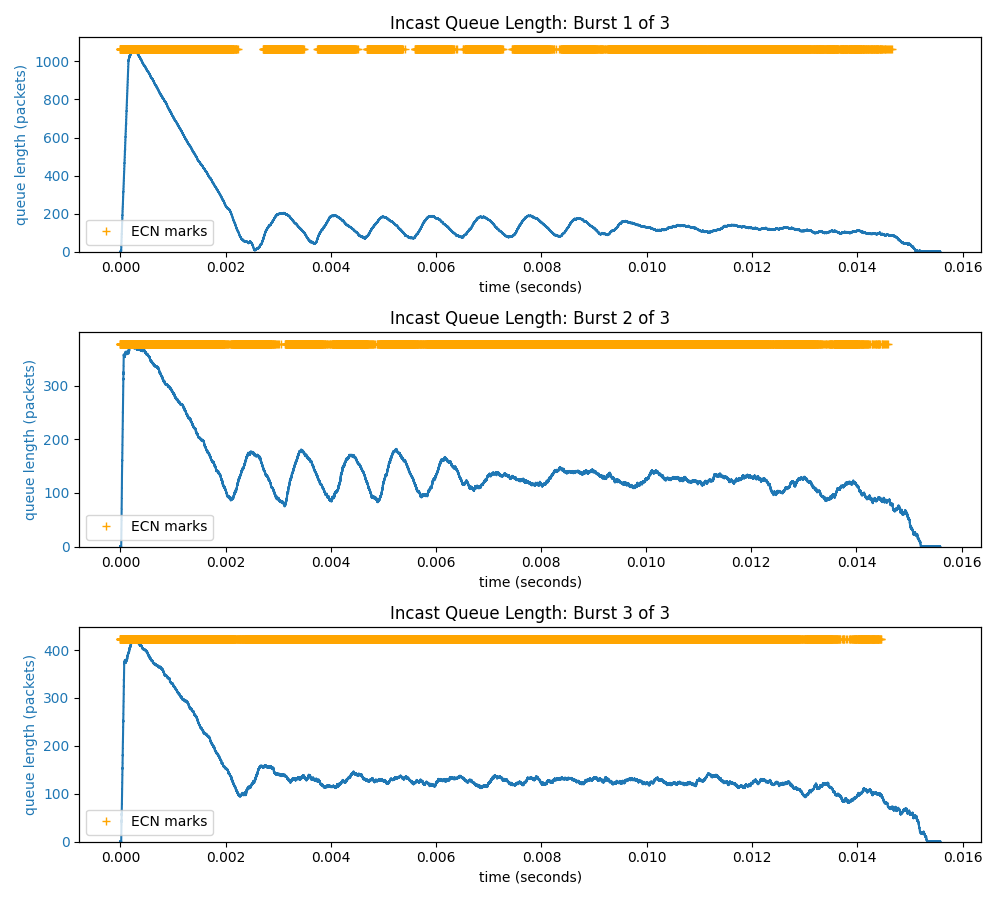

In [3]:
graph_queue(path.join(OUT_DIR, "log"), "Incast Queue", burst_times)

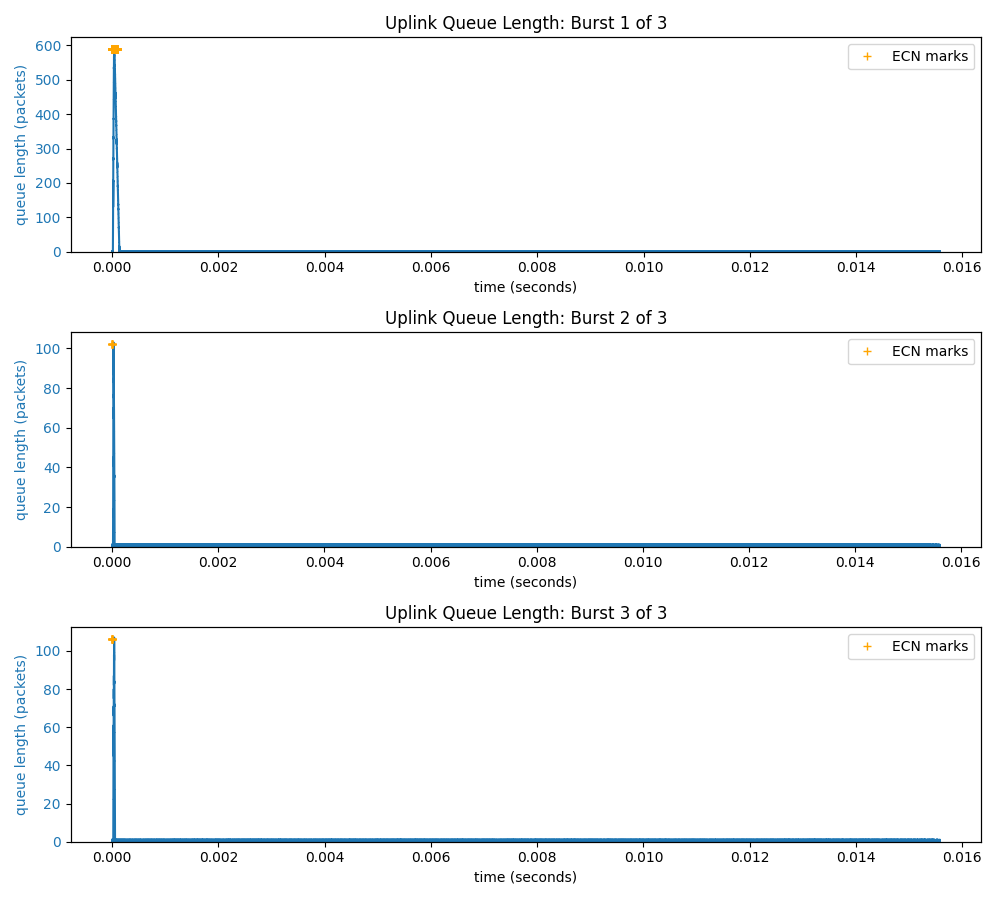

In [4]:
graph_queue(path.join(OUT_DIR, "log"), "Uplink Queue", burst_times)

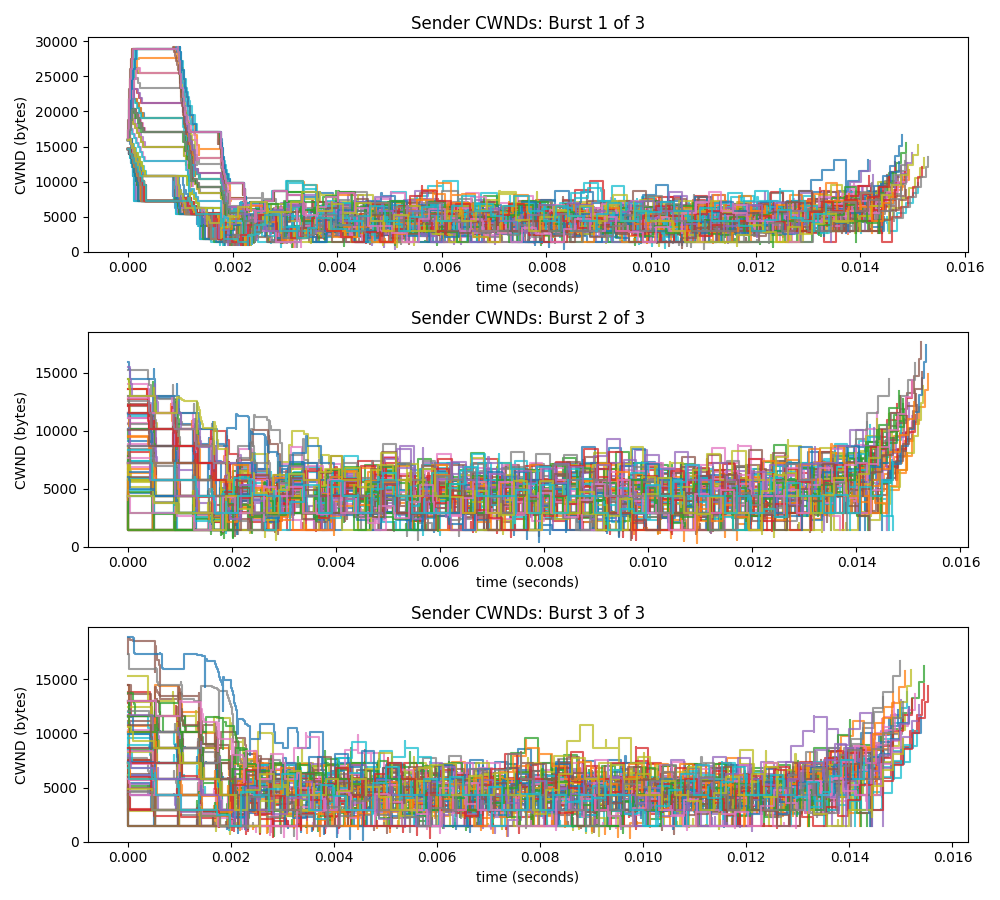

In [5]:
sender_to_cwnds_by_burst = graph_sender_cwnd(path.join(OUT_DIR, "log"), burst_times)

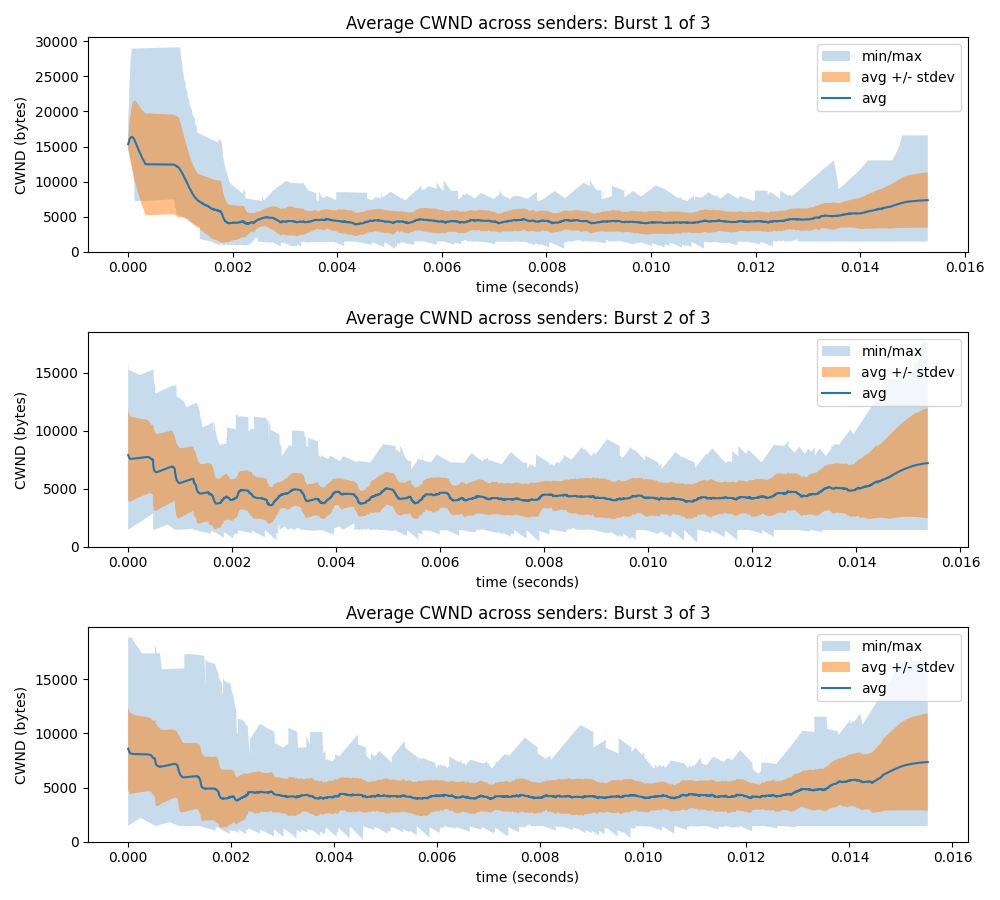

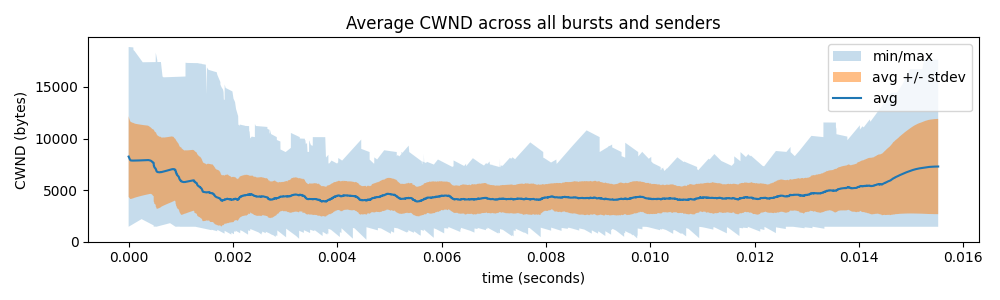

In [6]:
sender_to_cwnds_by_burst_interp = graph_avg_cwnd(sender_to_cwnds_by_burst, len(burst_times))

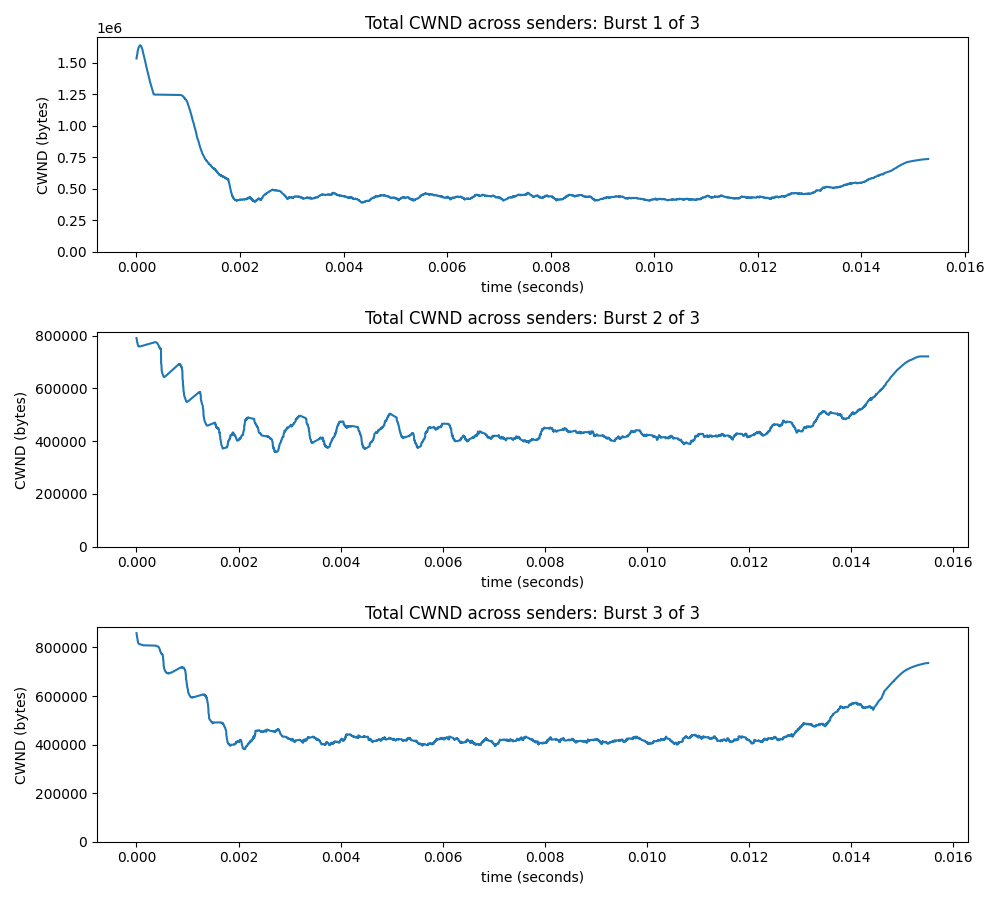

In [7]:
graph_total_cwnd(sender_to_cwnds_by_burst_interp, len(burst_times))